In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv(r"C:\Users\ADMIN\Downloads\loan_data_2007_2014_preprocessed.csv")
data.head(10)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15220\4108845966.py:1: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\ADMIN\Downloads\loan_data_2007_2014_preprocessed.csv")


,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1
5,5,5,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,...,0,0,0,0,0,0,0,1,0,1
6,6,6,1069639,1304742,7000,7000,7000.0,60 months,15.96,170.08,...,0,0,0,0,0,0,0,1,0,1
7,7,7,1072053,1288686,3000,3000,3000.0,36 months,18.64,109.43,...,0,0,0,0,0,0,0,1,0,1
8,8,8,1071795,1306957,5600,5600,5600.0,60 months,21.28,152.39,...,0,0,0,0,0,0,0,1,0,0
9,9,9,1071570,1306721,5375,5375,5350.0,60 months,12.69,121.45,...,0,0,0,0,0,0,0,1,0,0


In [3]:
data.shape

(466285, 209)

In [4]:
data.isna().sum()

Unnamed: 0.1             0
Unnamed: 0               0
id                       0
member_id                0
loan_amnt                0
                        ..
addr_state:WV            0
addr_state:WY            0
initial_list_status:f    0
initial_list_status:w    0
good_bad                 0
Length: 209, dtype: int64

In [5]:
pd.set_option('display.max_columns', 500) 
pd.set_option('display.max_rows', 500)
data.head(10)

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,earliest_cr_line_date,mths_since_earliest_cr_line,term_int,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.00,0.00,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000.0,NaN,NaN,NaN,10.0,1985-01-01,395.0,36,2011-12-01,72.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder

In [6]:
LEAKAGE_COLS = [
    "out_prncp", "out_prncp_inv",
    "total_pymnt", "total_pymnt_inv",
    "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries",
    "collection_recovery_fee",
    "last_pymnt_d", "last_pymnt_amnt",
    "next_pymnt_d", "last_credit_pull_d"
]


In [7]:
leakage_status_cols = [c for c in data.columns if c.startswith("loan_status")]
data = data.drop(columns=LEAKAGE_COLS + leakage_status_cols, errors="ignore")

In [8]:
data.shape

(466285, 186)

In [9]:
data.head(5)

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,earliest_cr_line_date,mths_since_earliest_cr_line,term_int,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000.0,NaN,NaN,NaN,10.0,1985-01-01,395.0,36,2011-12-01,72.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500.0,NaN,NaN,NaN,0.0,1999-04-01,224.0,60,2011-12-01,72.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,

In [10]:
print(data['issue_d_date'].dtype)

object


In [11]:
data['issue_d_date'] = pd.to_datetime(data['issue_d_date'])

data = data.sort_values('issue_d_date')

train = data[data['issue_d_date'] < '2014-01-01'].copy()
test = data[data['issue_d_date'] >= '2014-01-01'].copy()

print(f"Train Date Range: {train['issue_d_date'].min()} to {train['issue_d_date'].max()}")
print(f"Test Date Range: {test['issue_d_date'].min()} to {test['issue_d_date'].max()}")
print(f'Train data: {len(train)}')
print(f'Test Data: {len(test)}')

Train Date Range: 2007-06-01 00:00:00 to 2013-12-01 00:00:00
Test Date Range: 2014-01-01 00:00:00 to 2014-12-01 00:00:00
Train data: 230657
Test Data: 235628


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

baseline_features = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 
    'inq_last_6mths', 'revol_util', 'emp_length_int'
]

x_train, y_train = train[baseline_features], train['good_bad']
x_test, y_test = test[baseline_features], test['good_bad']

baseline_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced', random_state=42))
])

baseline_pipe.fit(x_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. I

In [13]:
from sklearn.metrics import roc_auc_score, average_precision_score

probs = baseline_pipe.predict_proba(x_test)[:, 1]

print(f"Baseline ROC-AUC: {roc_auc_score(y_test, probs):.3f}")
print(f"Baseline PR-AUC (Average Precision): {average_precision_score(y_test, probs):.3f}")

Baseline ROC-AUC: 0.684
Baseline PR-AUC (Average Precision): 0.957


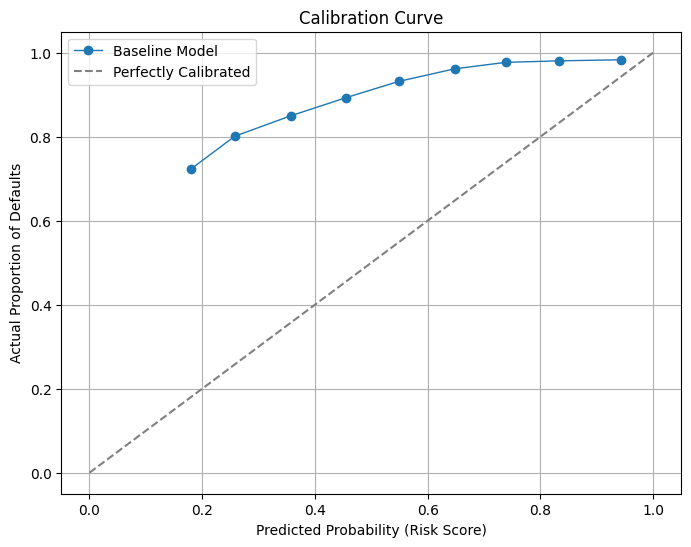

In [14]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Baseline Model')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Predicted Probability (Risk Score)')
plt.ylabel('Actual Proportion of Defaults')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, probs)
print(f"Brier Score: {brier:.4f}")

Brier Score: 0.2281


In [16]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

x_train_sub, x_calib, y_train_sub, y_calib = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

baseline_pipe.fit(x_train_sub, y_train_sub)

calibrator = CalibratedClassifierCV(baseline_pipe, method='isotonic', cv=5)
calibrator.fit(x_calib, y_calib)

calibrated_probs = calibrator.predict_proba(x_test)[:, 1]

new_brier = brier_score_loss(y_test, calibrated_probs)
print(f"New Calibrated Brier Score: {new_brier:.4f}")

New Calibrated Brier Score: 0.0763


In [17]:
test['issue_quarter'] = test['issue_d_date'].dt.to_period('Q')

def evaluate_quarter(group):
    probs = calibrator.predict_proba(group[baseline_features])[:, 1]
    actuals = group['good_bad']
    return pd.Series({
        'auc_roc': roc_auc_score(actuals, probs),
        'brier_score': brier_score_loss(actuals, probs),
        'sample_size': len(group)
    })

quarterly_analysis = test.groupby('issue_quarter').apply(evaluate_quarter, include_groups=False).reset_index()
quarterly_analysis['issue_quarter'] = quarterly_analysis['issue_quarter'].astype(str)
print(quarterly_analysis)

  issue_quarter   auc_roc  brier_score  sample_size
0        2014Q1  0.666939     0.089652      47410.0
1        2014Q2  0.668230     0.084510      55349.0
2        2014Q3  0.682318     0.075717      58726.0
3        2014Q4  0.702174     0.062030      74143.0


In [18]:
full_auc = quarterly_analysis['auc_roc'].mean()
full_brier = quarterly_analysis['brier_score'].mean()

print(f"Full Model Reference - AUC: {full_auc:.4f}, Brier: {full_brier:.4f}\n")

Full Model Reference - AUC: 0.6799, Brier: 0.0780



In [19]:
results = []
for feature_to_drop in baseline_features:
    reduced_features = [f for f in baseline_features if f != feature_to_drop]
    x_train_reduced = x_train_sub[reduced_features]
    x_calib_reduced = x_calib[reduced_features]
    x_test_reduced = x_test[reduced_features]
    
    reduced_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(class_weight='balanced', random_state=42))
    ])
    reduced_pipe.fit(x_train_reduced, y_train_sub)

    calibrator_reduced = CalibratedClassifierCV(reduced_pipe, method='isotonic', cv=5)
    calibrator_reduced.fit(x_calib_reduced, y_calib)
    calibrator_probs_reduced = calibrator_reduced.predict_proba(x_test_reduced)[:, 1]

    auc_drop = full_auc - roc_auc_score(y_test, calibrator_probs_reduced)
    brier_change = brier_score_loss(y_test, calibrator_probs_reduced) - full_brier

    results.append({
        'Dropped Feature': feature_to_drop,
        'AUC Drop': auc_drop,
        'Brier Increase': brier_change
    })

ablation_df = pd.DataFrame(results).sort_values(by='AUC Drop', ascending=False)
print(ablation_df)

  Dropped Feature  AUC Drop  Brier Increase
1        int_rate  0.068325        0.000019
4  inq_last_6mths -0.002375       -0.001257
3             dti -0.002569       -0.001769
6  emp_length_int -0.002661       -0.001662
2      annual_inc -0.002976       -0.001670
0       loan_amnt -0.003324       -0.001711
5      revol_util -0.004006       -0.001640
